<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
RANDOM_STATE = 42

### Подгружаем данные

По условиям задания, данные уже разделены на train и test. В практике генеральная совокупность данных делиться на следующие выборки:
  <ul>
   <li><b>DEV</b> - выборка для разработки модели</li>
   <li><b>OOT</b> (out of time) - максимально свежие данные, предназанченные для тестирвования/валидации с целью понимания, что было бы если бы мы модель использовали сейчас.</li>
   <li><b>OOS</b> (out of samle) - выборка предназанченная для тестирования/валидации, совпадающая по временому горизонту с выборкой для разработки. Формирование выборки OOS произовдится со стратификацией уровня дефолта относительно DEV</li>
  </ul>
<p><img src="https://dsbattle.com/assets/images/dev-oos-oot.png" width="700" alt="lorem"></p>

<i>Стратификация — метод выбора подмножества объектов из генеральной совокупности, разбитой на подмножества (страты). При стратификации объекты выбираются таким образом, чтобы итоговая выборка сохраняла соотношения размеров страт.</i>

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv

--2021-05-11 20:20:55--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv.4’

PD-data-train.csv.4 100%[===================>]   5.08M  24.6MB/s    in 0.2s    

2021-05-11 20:20:56 (24.6 MB/s) - ‘PD-data-train.csv.4’ saved [5329268/5329268]

--2021-05-11 20:20:56--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')

Семплы и размеры выборок

In [ ]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0


In [ ]:
train_df.shape

(32395, 37)

In [ ]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,3558000.0,0.0,677000.0,47000.0,1178000.0,6130000.0,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,138000.0,0.0,237000.0,1467000.0,6835000.0,3906000.0,0.0,0.0,3906000.0,0.0,244,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,1476000.0,0.0,35000.0,137000.0,5691000.0,540000.0,0.0,500000.0,40000.0,0.0,272,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,19479000.0,0.0,956000.0,1739000.0,12408000.0,47017000.0,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [ ]:
test_df.shape

(200, 36)

Уровень дефолт-рейта в выборке = 6,4547%

In [ ]:
train_df['default_12m'].values.mean()

0.06454699799351751

PD модель должна возвращать ожидаемый уровень дефолта, чтобы избежать переоценки или недооценки кредитного риска. Для этого делается калибровка модели (в текущем задании это делать не нужно). Бывает два типа калибровки:
  <ul>
   <li><b>TTC</b> (through the cycle) - модель калибруется на среднее значение PD за полный экономический цикл, чтобы в долгосрочной перспективе адекватно оценивать риск, независимо от стадии экономического цикла.</li>
   <li><b>PIT</b> (point in time) - модель калибруется на текущий уровень дефолта (обычно за полседний доступный год), чтобы адекватно оценивать рисккраткосрочной перспективе в текущей стадии экономического цикла.</li>
  </ul>

  <p><img src="https://dsbattle.com/assets/images/calib.png" width="700" alt="lorem"></p>

### Сгенерируем новые относительные признаки 

Объединим обучающую и тестовую выборки для того, чтобы сгенерировать новые признаки сразу для всех выборок

In [ ]:
df = pd.concat([train_df, test_df], sort=False)

In [ ]:
TL = df.ab_long_term_liabilities + df.ab_other_borrowings + df.ab_short_term_borrowing
TA = df.ab_own_capital + df.ab_borrowed_capital
STD = df.ab_short_term_borrowing
STFD = df.ab_short_term_borrowing
CA = df.ab_mobile_current_assets
FCA = df.ab_mobile_current_assets - df.ab_inventory
GY = df.ar_sale_profit

df['r_1_a'] =  df.ar_revenue / (df.ab_accounts_receivable/12) 
df['r_2_a'] = df.ar_sale_cost / (df.ab_inventory/12)
df['r_3_a'] = df.ar_selling_expenses / (df.ar_total_expenses/12)
df['r_4_a'] = df.ar_revenue / TA -TL
df['r_5_a'] = df.ar_revenue / (df.ab_immobilized_assets/12)
df['r_6_a'] = df.ar_revenue / (df.ab_mobile_current_assets + df.ab_cash_and_securities)
df['r_7_a'] = df.ar_sale_profit / df.ar_revenue
df['r_8_a'] = df.ar_profit_before_tax / df.ar_revenue
df['r_9_a'] = df.ar_net_profit / df.ar_revenue

df['r_10_a'] = df.ab_short_term_borrowing / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_11_a'] = df.ab_accounts_payable / (df.ab_short_term_borrowing + df.ab_accounts_payable + df.ab_other_borrowings)
df['r_12_a'] = df.ab_inventory / df.ar_revenue
df['r_13_a'] = df.ab_long_term_liabilities / df.ar_revenue
df['r_15_a'] = df.ar_taxes / df.ar_revenue

df['r_16_a'] = df.ab_inventory / df.ab_borrowed_capital
df['r_17_a'] = df.ab_inventory / df.ab_mobile_current_assets
df['r_18_a'] = df.ab_inventory / df.ab_accounts_payable

df['r_19_a'] = df.ab_accounts_receivable / (df.ab_cash_and_securities + df.ab_accounts_receivable)
df['r_20_a'] = df.ab_cash_and_securities / df.ab_borrowed_capital
df['r_21_a'] = df.ab_cash_and_securities / df.ab_short_term_borrowing
df['r_22_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable)
df['r_23_a'] = df.ab_cash_and_securities / (df.ab_short_term_borrowing + df.ab_accounts_payable + df. ab_other_borrowings)

df['r_24_a'] = df.ar_profit_before_tax / df.ar_net_profit

df['r_25_a'] = TL / TA
df['r_26_a'] = (df.ab_accounts_receivable + df.ab_cash_and_securities) / TA
df['r_27_a'] = CA / STD


In [ ]:
df

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0.0,282.394316,116.304731,0.000000,-1.134900e+07,inf,7.070847,0.087780,0.038569,0.022605,0.715033,0.284967,0.094120,0.000000,0.015963,0.314264,0.688950,1.102808,0.898285,0.016066,0.022469,0.016066,0.016066,1.706177,0.686362,0.151618,0.637942
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0.0,2359.435583,86.922097,0.000000,-3.651995e+06,inf,7.505621,0.077413,0.069300,0.059877,1.000000,0.000000,0.127367,0.000000,0.009423,1.117744,0.961602,inf,0.867021,0.006846,0.006846,0.006846,0.006846,1.157374,0.622041,0.032022,1.162377
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0.0,574.116279,20.825006,0.000000,1.199738e+00,inf,1.743063,0.092539,0.075890,0.043201,0.000000,1.000000,0.522907,0.000000,0.032689,6.728694,0.961564,6.728694,0.411483,0.384676,inf,0.384676,0.384676,1.756681,0.000000,0.060942,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,265577,21287000.0,18838000.0,16227000.0,2611000.0,0.0,2449000.0,-123000.0,2326000.0,483000.0,0.0,1843000.0,180000.0,8424000.0,6444000.0,1979000.0,1000.0,2534000.0,1846000.0,4424000.0,6714000.0,1216000.0,0.0,5498000.0,0.0,47,47,32,32,32,[1-100],10000.0,1,0,0,0,NaN,129.077312,30.217877,1.663234,-1.215998e+06,1419.133333,1.942599,0.115047,0.109269,0.086579,0.000000,1.000000,0.302720,0.057124,0.022690,0.959786,0.764957,1.172063,0.438511,0.377420,inf,0.460895,0.460895,1.262073,0.109176,0.405189,inf
196,266648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283,140,6,6,6,[1-100],0.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,266849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,22,7,7,7,[1-100],20000.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

все абсолютные признаки убираем кроме чистой прибыли, оставляем только относительные признаки

Также убираем признак ul_systematizing_flg так как у нее единственное значение на всей выборке

In [ ]:
df_short = df.drop(['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
         'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 
         'ar_other_profit_and_losses', 'ul_systematizing_flg'], axis = 1)

In [ ]:
df_short

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
0,7,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0.0,282.394316,116.304731,0.000000,-1.134900e+07,inf,7.070847,0.087780,0.038569,0.022605,0.715033,0.284967,0.094120,0.000000,0.015963,0.314264,0.688950,1.102808,0.898285,0.016066,0.022469,0.016066,0.016066,1.706177,0.686362,0.151618,0.637942
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0.0,2359.435583,86.922097,0.000000,-3.651995e+06,inf,7.505621,0.077413,0.069300,0.059877,1.000000,0.000000,0.127367,0.000000,0.009423,1.117744,0.961602,inf,0.867021,0.006846,0.006846,0.006846,0.006846,1.157374,0.622041,0.032022,1.162377
4,23,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0.0,574.116279,20.825006,0.000000,1.199738e+00,inf,1.743063,0.092539,0.075890,0.043201,0.000000,1.000000,0.522907,0.000000,0.032689,6.728694,0.961564,6.728694,0.411483,0.384676,inf,0.384676,0.384676,1.756681,0.000000,0.060942,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,265577,1843000.0,180000.0,8424000.0,6444000.0,1979000.0,1000.0,2534000.0,1846000.0,4424000.0,6714000.0,1216000.0,0.0,5498000.0,0.0,47,47,32,32,32,[1-100],10000.0,1,0,0,NaN,129.077312,30.217877,1.663234,-1.215998e+06,1419.133333,1.942599,0.115047,0.109269,0.086579,0.000000,1.000000,0.302720,0.057124,0.022690,0.959786,0.764957,1.172063,0.438511,0.377420,inf,0.460895,0.460895,1.262073,0.109176,0.405189,inf
196,266648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283,140,6,6,6,[1-100],0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,266849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,22,7,7,7,[1-100],20000.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,267566,8615000.0,205310000.0,232128000.0,108986000.0,115331000.0,7811000.0,1515000.0,8615000.0,125575000.0,313378000.0,145888000.0,99847000.0,67643000.0,0.0,140,140,31,31,31,[1-100],100000.0,2,0,0,NaN,78.973632,60.767768,0.302575,-2.457350e+08,44.362710,3.248584,0.042591,0.011918,0.011350,0.596137,0.403863,0.143590,0.192209,0.000568,0.347778,0.469508,1.611194,0.987034,0.004834,0.015173,0.009045,0.009045,1.050029,0.559821,0.266193,2.324837


Преобразуем категориальный признак 'ul_staff_range'. В данном случае можно категории просто заменить на числа,сохраняя порядок, так как для категорий данного признака поряд задан.

In [ ]:
df_short['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [ ]:
df_short.loc[df_short['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
df_short.loc[df_short['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2
df_short.loc[df_short['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3

In [ ]:
df_short

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
0,7,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,1,50000.0,2,0,0,0.0,282.394316,116.304731,0.000000,-1.134900e+07,inf,7.070847,0.087780,0.038569,0.022605,0.715033,0.284967,0.094120,0.000000,0.015963,0.314264,0.688950,1.102808,0.898285,0.016066,0.022469,0.016066,0.016066,1.706177,0.686362,0.151618,0.637942
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,1,10000.0,5,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,1,10000.0,2,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,1,300000.0,1,0,0,0.0,2359.435583,86.922097,0.000000,-3.651995e+06,inf,7.505621,0.077413,0.069300,0.059877,1.000000,0.000000,0.127367,0.000000,0.009423,1.117744,0.961602,inf,0.867021,0.006846,0.006846,0.006846,0.006846,1.157374,0.622041,0.032022,1.162377
4,23,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,1,10000.0,2,0,0,0.0,574.116279,20.825006,0.000000,1.199738e+00,inf,1.743063,0.092539,0.075890,0.043201,0.000000,1.000000,0.522907,0.000000,0.032689,6.728694,0.961564,6.728694,0.411483,0.384676,inf,0.384676,0.384676,1.756681,0.000000,0.060942,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,265577,1843000.0,180000.0,8424000.0,6444000.0,1979000.0,1000.0,2534000.0,1846000.0,4424000.0,6714000.0,1216000.0,0.0,5498000.0,0.0,47,47,32,32,32,1,10000.0,1,0,0,NaN,129.077312,30.217877,1.663234,-1.215998e+06,1419.133333,1.942599,0.115047,0.109269,0.086579,0.000000,1.000000,0.302720,0.057124,0.022690,0.959786,0.764957,1.172063,0.438511,0.377420,inf,0.460895,0.460895,1.262073,0.109176,0.405189,inf
196,266648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283,140,6,6,6,1,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,266849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,22,7,7,7,1,20000.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,267566,8615000.0,205310000.0,232128000.0,108986000.0,115331000.0,7811000.0,1515000.0,8615000.0,125575000.0,313378000.0,145888000.0,99847000.0,67643000.0,0.0,140,140,31,31,31,1,100000.0,2,0,0,NaN,78.973632,60.767768,0.302575,-2.457350e+08,44.362710,3.248584,0.042591,0.011918,0.011350,0.596137,0.403863,0.143590,0.192209,0.000568,0.347778,0.469508,1.611194,0.987034,0.004834,0.015173,0.009045,0.009045,1.050029,0.559821,0.266193,2.324837


In [ ]:
df_short.loc[df['record_id']==47190].index.values

array([38])

In [ ]:
df_short.loc[df_short['record_id'] == 47190]
#new

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
38,47190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,56,26,26,26,1,10000.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разбиваем на трейн и тест назад


In [ ]:
test_df_new = df_short.iloc[-200:,:]

In [ ]:
train_df_new = df_short.iloc[:-200, :]

Существует два подоха к выбору объекта оценки:
  <ul>
   <li><b>Розничный</b> (портфельный) - моделирование проводится на уровне кредитного требования (кредита).</li>
   <li><b>Корпоративный</b> (индивидуальный) - моделирование проводится на уровне субъекта (клиента).</li>
  </ul>
В текущем задании применим корпоративный подход и выполним моделирование на уровне клиента. Дубликаты с разным record_id, но одинаковыми остальными значениями признаков. Удаляем их из трейна

In [ ]:
column_list = list(train_df_new.columns)
subset = column_list.copy()


train_df_new.drop_duplicates(subset=subset, inplace = True)


Разбиваем на 2 выборки по наличию финансовой отчетности

In [ ]:
train_df_ip = train_df_new[train_df_new['ar_net_profit'].isnull()]
train_df_phys = train_df_new[~train_df_new['ar_net_profit'].isnull()]

In [ ]:
train_df_ip.shape

(15145, 52)

In [ ]:
train_df_phys.shape

(17250, 52)

Удалим столбцы в которых есть пропуски для данных без фин отчетности

In [ ]:
nan_colmn_ip = train_df_ip.columns[train_df_ip.isnull().any()]

In [ ]:
train_df_ip.drop(nan_colmn_ip, axis = 1, inplace = True)

Пропуски в таблице с фин отчетностью только в новых признаках. Заполним их нулями, вероятно мы где-то поделили на ноль.

In [ ]:
train_df_phys.fillna(0, inplace = True)

In [ ]:
df_short

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
0,7,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198,136,3,3,3,1,50000.0,2,0,0,0.0,282.394316,116.304731,0.000000,-1.134900e+07,inf,7.070847,0.087780,0.038569,0.022605,0.715033,0.284967,0.094120,0.000000,0.015963,0.314264,0.688950,1.102808,0.898285,0.016066,0.022469,0.016066,0.016066,1.706177,0.686362,0.151618,0.637942
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256,135,12,12,12,1,10000.0,5,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,33,28,28,28,1,10000.0,2,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185,139,8,8,8,1,300000.0,1,0,0,0.0,2359.435583,86.922097,0.000000,-3.651995e+06,inf,7.505621,0.077413,0.069300,0.059877,1.000000,0.000000,0.127367,0.000000,0.009423,1.117744,0.961602,inf,0.867021,0.006846,0.006846,0.006846,0.006846,1.157374,0.622041,0.032022,1.162377
4,23,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220,138,27,27,27,1,10000.0,2,0,0,0.0,574.116279,20.825006,0.000000,1.199738e+00,inf,1.743063,0.092539,0.075890,0.043201,0.000000,1.000000,0.522907,0.000000,0.032689,6.728694,0.961564,6.728694,0.411483,0.384676,inf,0.384676,0.384676,1.756681,0.000000,0.060942,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,265577,1843000.0,180000.0,8424000.0,6444000.0,1979000.0,1000.0,2534000.0,1846000.0,4424000.0,6714000.0,1216000.0,0.0,5498000.0,0.0,47,47,32,32,32,1,10000.0,1,0,0,NaN,129.077312,30.217877,1.663234,-1.215998e+06,1419.133333,1.942599,0.115047,0.109269,0.086579,0.000000,1.000000,0.302720,0.057124,0.022690,0.959786,0.764957,1.172063,0.438511,0.377420,inf,0.460895,0.460895,1.262073,0.109176,0.405189,inf
196,266648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283,140,6,6,6,1,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,266849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,22,7,7,7,1,20000.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,267566,8615000.0,205310000.0,232128000.0,108986000.0,115331000.0,7811000.0,1515000.0,8615000.0,125575000.0,313378000.0,145888000.0,99847000.0,67643000.0,0.0,140,140,31,31,31,1,100000.0,2,0,0,NaN,78.973632,60.767768,0.302575,-2.457350e+08,44.362710,3.248584,0.042591,0.011918,0.011350,0.596137,0.403863,0.143590,0.192209,0.000568,0.347778,0.469508,1.611194,0.987034,0.004834,0.015173,0.009045,0.009045,1.050029,0.559821,0.266193,2.324837


In [ ]:
df_short.loc[df_short['record_id'] == 47190]

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
38,47190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56,56,26,26,26,1,10000.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Stop here !!!
df_short

### Модель для данных без фин отчетности

Разобьем данные на тестовую и обучающую выборки

In [ ]:
X_ip = train_df_ip.drop(['default_12m'], axis = 1)
y_ip = train_df_ip['default_12m']

In [ ]:
X_ip['ul_strategic_flg'].value_counts()

0    15145
Name: ul_strategic_flg, dtype: int64

Удаляем этот признак, так как он является константым для данных без фин отчетности. \\
Особенности работы библиотеки  riskpy, которая будет использоваться дальше для бинаризации, требует чтобы данные имели тип данных, занимающий <= количество бит чем float32


In [ ]:
X_ip.drop(['ul_strategic_flg'], axis = 1, inplace = True)
X_ip['ul_capital_sum'] = X_ip['ul_capital_sum'].astype(int)
X_ip['ul_staff_range'] = X_ip['ul_staff_range'].astype(int)
y_ip = y_ip.astype(int)

Разбиваем размеченные данные на обучающую и валидационную выборки

In [ ]:
from sklearn.model_selection import train_test_split
X_train_ip, X_test_ip, y_train_ip, y_test_ip = train_test_split(X_ip, y_ip, test_size=0.3, random_state=42)

### WOE
Для бинаризации признаков будет использовать библиотеку riskpy


In [ ]:
!pip install git+https://github.com/Falconwatch/riskpy.git@master

  Cloning https://github.com/Falconwatch/riskpy.git (to revision master) to /tmp/pip-req-build-sao0d9yj
  Running command git clone -q https://github.com/Falconwatch/riskpy.git /tmp/pip-req-build-sao0d9yj
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Created wheel for riskpy: filename=riskpy-0.0.4-cp37-none-any.whl size=31781 sha256=4aea2ce65717f603ecda946e9792d8abc8b8bfeaadc4682ef7cc4fdd55d6019e
  Stored in directory: /tmp/pip-ephem-wheel-cache-sn52lhph/wheels/4b/8b/30/1ff8c31ce3c64eb17909ee4b39a0ab6df6a06f7d2f75caabea
Successfully built riskpy


In [ ]:
from riskpy.modeling.binning import Binner
from riskpy.graphs.graphs import binning_barchart

Для работы библиотеки riskpy необходимо добавить таргет в данные

In [ ]:
X_train_ip['default_12m'] = y_train_ip
X_test_ip['default_12m'] = y_test_ip
X_ip['default_12m'] = y_ip

In [ ]:
X_train_ip

,record_id,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,default_12m
14323,121170,25,25,8,8,8,1,10000,1,0,0
21910,185751,165,139,2,2,2,1,105000,2,0,0
2472,20710,51,51,24,24,24,1,30000,2,0,0
8708,73260,203,138,16,16,16,1,10000,3,0,0
22270,188818,18,18,15,15,15,1,20000,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11028,92413,93,93,29,29,29,1,10000,2,0,0
28670,242767,75,75,27,27,27,1,10000,2,0,0
11442,96035,108,108,21,21,21,1,10000,1,0,0
1840,15499,16,16,2,2,2,1,10000,1,0,1


In [ ]:
binner_ip = Binner()
bins = binner_ip.fit(X_train_ip, 'default_12m')
X_train_woe_ip = binner_ip.transform(X_train_ip)
X_test_woe_ip = binner_ip.transform(X_test_ip)

In [ ]:
X_test_woe_ip

,record_id_woe,bus_age_woe,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,cap_actual_age_woe,ul_capital_sum_woe,ul_founders_cnt_woe,default_12m
1192,-0.01949,-0.385900,-0.391808,-0.318294,-0.318294,-0.318294,-0.034298,0.103912,0
9209,-0.01949,-0.212093,-0.216575,0.453953,0.453953,0.453953,-0.034298,0.103912,0
4485,-0.01949,-0.385900,-0.391808,-0.120411,-0.120411,-0.120411,-0.034298,-0.111593,0
19047,-0.01949,0.181061,0.183628,0.453953,0.453953,0.453953,-0.034298,0.103912,0
21050,-0.01949,-0.212093,-0.216575,-0.120411,-0.120411,-0.120411,-0.034298,0.103912,0
...,...,...,...,...,...,...,...,...,...
28628,0.08588,0.626482,0.677371,-0.318294,-0.318294,-0.318294,-0.034298,-0.111593,0
20855,-0.01949,-0.385900,-0.391808,-0.120411,-0.120411,-0.120411,-0.034298,-0.111593,0
25771,-0.01949,0.626482,0.677371,0.102694,0.102694,0.102694,-0.034298,0.656191,0
5735,-0.01949,0.181061,0.183628,0.453953,0.453953,0.453953,-0.034298,0.103912,1


### Отбор признаков


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

Экспериментально было подобрано, что 4 признака в данной задаче для данных без фин отчетности является оптимальным и позволяет убрать все коррелирующие признаки

In [ ]:
FEATURE_COUNT = 4
N_SPLITS = 3

In [ ]:
y_train_woe_ip = X_train_woe_ip['default_12m']
y_test_woe_ip = X_test_woe_ip['default_12m']
X_train_woe_ip.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_ip.drop(['default_12m'], axis = 1, inplace = True)

In [ ]:
y_test_woe_ip

1192     0
9209     0
4485     0
19047    0
21050    0
        ..
28628    0
20855    0
25771    0
5735     1
4229     0
Name: default_12m, Length: 4544, dtype: int64

Запустим метод  Forward Selection для отбора признаков.

In [ ]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT , 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_ip, y_train_woe_ip)

Выведем отобранные признаки

In [ ]:
selector.subsets_[4]

{'avg_score': 0.6465186601967158,
 'cv_scores': array([0.62578904, 0.63635257, 0.67741437]),
 'feature_idx': (2, 3, 4, 7),
 'feature_names': ('ogrn_age_woe',
  'adr_actual_age_woe',
  'head_actual_age_woe',
  'ul_founders_cnt_woe')}

Построим карту корреляций для выбранных признаков.

In [ ]:
top_feat = list(selector.subsets_[FEATURE_COUNT]['feature_names'])
X_train_woe_ip[top_feat].corr()

,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,ul_founders_cnt_woe
ogrn_age_woe,1.000000,0.159345,0.159345,0.138293
adr_actual_age_woe,0.159345,1.000000,1.000000,-0.012590
head_actual_age_woe,0.159345,1.000000,1.000000,-0.012590
ul_founders_cnt_woe,0.138293,-0.012590,-0.012590,1.000000


Все корреляции меньше 0.5. <br>Эффективность моделей бинарной классификации наилучшим образом оценивает метрика ROC/AUC (<b>Gini</b>). Поэтому оценим значимость каждого признака, вычислив коэффициент <b>Gini</b>.

In [ ]:
gini_features = pd.DataFrame(index=top_feat, columns = ['Gini'])
for feat in top_feat:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_ip.loc[:, feat].values.reshape(-1,1), y_train_woe_ip)
    preds_train = logreg.predict_proba(X_train_woe_ip.loc[:, feat].values.reshape(-1,1))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_ip, preds_train) - 1

In [ ]:
gini_features

,Gini
ogrn_age_woe,0.229666
adr_actual_age_woe,0.165278
head_actual_age_woe,0.165278
ul_founders_cnt_woe,0.0870046


In [ ]:
X_train_woe_ip_final = X_train_woe_ip[top_feat]
X_test_woe_ip_final = X_test_woe_ip[top_feat]

In [ ]:
X_train_woe_ip_final

,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,ul_founders_cnt_woe
14323,-0.391808,-0.120411,-0.120411,-0.111593
21910,0.677371,-0.318294,-0.318294,0.103912
2472,-0.216575,0.453953,0.453953,0.103912
8708,0.677371,0.102694,0.102694,0.656191
22270,-0.391808,0.102694,0.102694,0.103912
...,...,...,...,...
11028,0.677371,0.453953,0.453953,0.103912
28670,0.183628,0.453953,0.453953,0.103912
11442,0.677371,0.102694,0.102694,-0.111593
1840,-0.391808,-0.318294,-0.318294,-0.111593


### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_ip_final, y_train_woe_ip):
        
        X_train, X_test = X_train_woe_ip_final.iloc[train_index,:], X_train_woe_ip_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_ip.iloc[train_index], y_train_woe_ip.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

In [ ]:
X_train

,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,ul_founders_cnt_woe
21910,0.677371,-0.318294,-0.318294,0.103912
22270,-0.391808,0.102694,0.102694,0.103912
18433,-0.391808,-0.318294,-0.318294,-0.111593
9955,-0.391808,0.453953,0.453953,-0.111593
16422,0.677371,0.102694,0.102694,-0.111593
...,...,...,...,...
25542,-0.391808,-0.318294,-0.318294,-0.111593
11028,0.677371,0.453953,0.453953,0.103912
28670,0.183628,0.453953,0.453953,0.103912
11442,0.677371,0.102694,0.102694,-0.111593


In [ ]:
print("Наилучший коэффициент L2 - регуляризации:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент L2 - регуляризации: 2.3000000000000007


### Строим Лассо регрессию

Обучаем модель на всей обучащей выборке (без валидации)

In [ ]:
logreg_ip = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 3.3)
logreg_ip.fit(X_train_woe_ip_final, y_train_woe_ip)
y_pred = logreg_ip.predict_proba(X_test_woe_ip_final)[:,1]
y_pred_train = logreg_ip.predict_proba(X_train_woe_ip_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe_ip, y_pred))
print("ROC AUC train:", roc_auc_score(y_train_woe_ip, y_pred_train))

ROC AUC val: 0.6447128320910525
ROC AUC train: 0.6464573682097674


### Модель для данных с фин отчетностью

Проделаем аналогичные действия для данных с фин отчетностью.

In [ ]:
train_df_phys['ul_strategic_flg'].value_counts()

0    17247
1        3
Name: ul_strategic_flg, dtype: int64

Убираем ul_strategic_flg так как практически константная переменная, убираем ul_branch_cnt так как не биннаризуется

In [ ]:
train_df_phys.drop(['ul_strategic_flg', 'ul_branch_cnt'], axis = 1, inplace = True)

In [ ]:
train_df_phys = train_df_phys.astype('float32')
train_df_phys = train_df_phys.replace([np.inf, -np.inf], 0)
X_phys = train_df_phys.drop(['default_12m'], axis = 1)
y_phys = train_df_phys['default_12m']

Разделяем данные на обучающую и валидационную выборки

In [ ]:
X_train_phys, X_test_phys, y_train_phys, y_test_phys = train_test_split(X_phys, y_phys, test_size=0.3, random_state=42)

In [ ]:
train_df_phys

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,default_12m,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a
0,7.0,1198000.0,0.0,7240000.0,4988000.0,2252000.0,0.0,255000.0,1198000.0,663000.0,15872000.0,0.0,11349000.0,4523000.0,0.0,198.0,136.0,3.0,3.0,3.0,1.0,50000.0,2.0,0.0,282.394318,116.304733,0.0,-1.134900e+07,0.00000,7.070847,0.087780,0.038569,0.022605,0.715033,0.284967,0.094120,0.0,0.015963,0.314264,0.688950,1.102808,0.898285,0.016066,0.022469,0.016066,0.016066,1.706177,0.686362,0.151618,0.637942
3,22.0,1919000.0,0.0,4245000.0,4082000.0,163000.0,0.0,25000.0,1919000.0,2219000.0,3652000.0,0.0,3652000.0,0.0,0.0,185.0,139.0,8.0,8.0,8.0,1.0,300000.0,1.0,0.0,2359.435547,86.922096,0.0,-3.651994e+06,0.00000,7.505620,0.077413,0.069300,0.059877,1.000000,0.000000,0.127367,0.0,0.009423,1.117744,0.961602,0.000000,0.867021,0.006846,0.006846,0.006846,0.006846,1.157374,0.622041,0.032022,1.162377
4,23.0,711000.0,0.0,8950000.0,8606000.0,344000.0,0.0,492000.0,711000.0,12439000.0,1279000.0,0.0,0.0,1279000.0,0.0,220.0,138.0,27.0,27.0,27.0,1.0,10000.0,2.0,0.0,574.116272,20.825006,0.0,1.199738e+00,0.00000,1.743063,0.092539,0.075890,0.043201,0.000000,1.000000,0.522907,0.0,0.032689,6.728694,0.961564,6.728694,0.411483,0.384676,0.000000,0.384676,0.384676,1.756681,0.000000,0.060942,0.000000
9,40.0,2135000.0,0.0,24680000.0,8263000.0,16417000.0,0.0,106000.0,2135000.0,11267000.0,11912000.0,0.0,13000.0,11899000.0,0.0,170.0,132.0,15.0,15.0,15.0,2.0,10000.0,2.0,0.0,91.684471,178.126587,0.0,-1.299459e+04,0.00000,5.060599,0.022139,0.021637,0.017021,0.001091,0.998909,0.065876,0.0,0.004616,0.693670,0.334806,0.694428,0.993585,0.008899,8.153846,0.008899,0.008899,1.271194,0.000561,0.712844,1898.461548
10,54.0,104000.0,0.0,38004000.0,23189000.0,14815000.0,0.0,449000.0,104000.0,10000.0,38443000.0,0.0,4986000.0,33457000.0,0.0,29.0,29.0,4.0,4.0,4.0,1.0,10000.0,2.0,0.0,48.251099,30.703005,0.0,-4.985998e+06,0.00000,1.549164,0.004012,0.002384,0.001746,0.129699,0.870301,0.389273,0.0,0.000638,0.603205,0.610173,0.693099,0.970584,0.011680,0.090052,0.011680,0.011680,1.365385,0.129665,0.396952,7.622142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32388,274557.0,0.0,5493000.0,5092000.0,2828000.0,2264000.0,0.0,928000.0,0.0,20000.0,11493000.0,0.0,1795000.0,9698000.0,0.0,83.0,83.0,2.0,2.0,2.0,1.0,25000.0,1.0,0.0,198.906357,134.202271,0.0,-1.794997e+06,81.98143,6.233721,0.157220,0.026488,0.000000,0.156182,0.843818,0.075359,0.0,0.026488,0.246063,0.555381,0.291607,0.709273,0.080745,0.516992,0.080745,0.080745,0.000000,0.155911,0.277252,2.836769
32390,274590.0,228000.0,0.0,10147000.0,3546000.0,6601000.0,0.0,639000.0,228000.0,-1597000.0,13826000.0,0.0,0.0,13826000.0,0.0,71.0,71.0,5.0,5.0,5.0,1.0,10000.0,1.0,0.0,51.381306,94.453468,0.0,2.311227e+00,0.00000,2.620434,0.012489,0.010083,0.008067,0.000000,1.000000,0.125460,0.0,0.002017,0.256473,0.349463,0.256473,0.911740,0.046217,0.000000,0.046217,0.046217,1.250000,0.000000,0.592035,0.000000
32391,274593.0,636000.0,3000.0,2977000.0,2046000.0,931000.0,0.0,7000.0,636000.0,2805000.0,182000.0,0.0,0.0,182000.0,0.0,168.0,141.0,25.0,25.0,25.0,1.0,600000.0,1.0,0.0,322.453278,142.997070,0.0,8.375293e+00,100068.00000,8.383713,0.025423,0.025423,0.025423,0.000000,1.000000,0.081784,0.0,0.000000,11.241758,0.687269,11.241758,0.992537,0.038462,0.000000,0.038462,0.038462,1.000000,0.000000,0.314027,0.000000
32393,274611.0,88000.0,0.0,203

In [ ]:
X_train_phys['default_12m'] = y_train_phys
X_test_phys['default_12m'] = y_test_phys

In [ ]:
X_train_phys

,record_id,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,r_1_a,r_2_a,r_3_a,r_4_a,r_5_a,r_6_a,r_7_a,r_8_a,r_9_a,r_10_a,r_11_a,r_12_a,r_13_a,r_15_a,r_16_a,r_17_a,r_18_a,r_19_a,r_20_a,r_21_a,r_22_a,r_23_a,r_24_a,r_25_a,r_26_a,r_27_a,default_12m
569,4785.0,-6290000.0,0.0,5656000.0,406000.0,5250000.0,0.0,39000.0,-6290000.0,7411000.0,7349000.0,0.0,1938000.0,5411000.0,0.0,232.0,141.0,4.0,4.0,4.0,1.0,85710.0,14.0,83.403427,1249.802979,0.000000,-1.937998e+06,0.000000,6.407199,-0.158842,-0.146236,-0.172381,0.263709,0.736291,0.011127,0.000000,0.026145,0.055246,0.071782,0.075032,0.992626,0.005307,0.020124,0.005307,0.005307,0.848331,0.131301,0.358333,2.918473,0.0
19559,165616.0,4952000.0,31950000.0,248099008.0,193138000.0,54961000.0,0.0,5333000.0,6106000.0,36895000.0,248487008.0,19449000.0,21569000.0,207388000.0,81000.0,205.0,129.0,4.0,4.0,4.0,2.0,2673000.0,2.0,54.678482,14.799532,0.000000,-4.109900e+07,94.058968,0.988163,0.048860,0.034237,0.019774,0.094172,0.905474,0.771219,0.077662,0.014467,0.777256,0.778471,0.931288,0.911550,0.021462,0.247253,0.023293,0.023284,1.731422,0.144014,0.211275,11.502573,0.0
3211,26860.0,10397000.0,0.0,57926000.0,6161000.0,51765000.0,0.0,633000.0,10397000.0,50792000.0,8159000.0,0.0,1312000.0,6847000.0,0.0,115.0,115.0,2.0,2.0,2.0,1.0,10000000.0,1.0,17.920603,130.319107,0.000000,-1.311999e+06,0.000000,1.320122,0.134493,0.134493,0.134493,0.160804,0.839196,0.079697,0.000000,0.000000,0.755117,0.106360,0.899810,0.987919,0.077583,0.482469,0.077583,0.077583,1.000000,0.022256,0.888840,44.150913,0.0
7233,60823.0,-9000.0,0.0,32000.0,0.0,32000.0,0.0,47000.0,-9000.0,1000.0,79000.0,0.0,1000.0,78000.0,0.0,15.0,15.0,3.0,3.0,3.0,1.0,10000.0,1.0,69.000000,0.000000,0.000000,-9.977000e+02,0.000000,2.329114,-0.027174,-0.048913,-0.048913,0.012658,0.987342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.405063,0.594937,47.000000,0.594937,0.594937,1.000000,0.012500,0.987500,32.000000,0.0
14117,119530.0,19572000.0,0.0,49982000.0,48961000.0,1021000.0,0.0,3495000.0,19572000.0,90852000.0,2428000.0,0.0,0.0,2428000.0,0.0,101.0,101.0,3.0,3.0,3.0,1.0,10000.0,1.0,632.462280,10.491452,0.000000,5.768868e-01,0.000000,1.006264,0.204527,0.363711,0.363711,0.000000,1.000000,0.909853,0.000000,0.000000,20.165157,0.979573,20.165157,0.226085,1.439456,0.000000,1.439456,1.439456,1.000000,0.000000,0.048413,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21252,180032.0,1538000.0,0.0,5921000.0,5384000.0,537000.0,0.0,289000.0,1538000.0,6950000.0,1013000.0,0.0,0.0,1013000.0,0.0,228.0,140.0,8.0,8.0,8.0,1.0,39470.0,3.0,537.966492,50.141903,0.000000,3.023232e+00,0.000000,3.876651,0.065506,0.075600,0.063886,0.000000,1.000000,0.223644,0.000000,0.011714,5.314906,0.909306,5.314906,0.650121,0.285291,0.000000,0.285291,0.285291,1.183355,0.000000,0.103730,0.000000,0.0
22510,190806.0,14616000.0,111925000.0,83491000.0,83215000.0,276000.0,0.0,3000.0,14332000.0,131786000.0,63633000.0,24779000.0,2480000.0,5566000.0,30808000.0,112.0,112.0,12.0,12.0,12.0,2.0,40000.0,3.0,3913.739014,11.926455,0.030242,-5.806700e+07,9.651034,1.078113,0.078697,0.160794,0.162371,0.063829,0.143254,0.924447,0.275273,0.000000,1.307733,0.996694,14.950593,0.989247,0.000047,0.001210,0.000373,0.000077,0.990285,0.297141,0.001428,33.665726,0.0
10172,85307.0,208000.0,0.0,15547000.0,6001000.0,9546000.0,0.0,1042000.0,208000.0,616000.0,18373000.0,0.0,542000.0,17831000.0,0.0,38.0,38.0,25.0,25.0,25.0,1.0,10000.0,1.0,68.492775,108.851860,0.000000,-5.419971e+05,0.000000,3.284466,0.000936,0.005066,0.003817,0.

Проводим бинаризацию признаков

In [ ]:
binner_phys = Binner()
bins = binner_phys.fit(X_train_phys, 'default_12m')
X_train_woe_phys = binner_phys.transform(X_train_phys)
X_test_woe_phys = binner_phys.transform(X_test_phys)

In [ ]:
X_train_woe_phys

,record_id_woe,ar_net_profit_woe,ab_immobilized_assets_woe,ab_mobile_current_assets_woe,ab_inventory_woe,ab_accounts_receivable_woe,ab_other_current_assets_woe,ab_cash_and_securities_woe,ab_losses_woe,ab_own_capital_woe,ab_borrowed_capital_woe,ab_long_term_liabilities_woe,ab_short_term_borrowing_woe,ab_accounts_payable_woe,ab_other_borrowings_woe,bus_age_woe,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,cap_actual_age_woe,ul_staff_range_woe,ul_capital_sum_woe,ul_founders_cnt_woe,r_1_a_woe,r_2_a_woe,r_3_a_woe,r_4_a_woe,r_5_a_woe,r_6_a_woe,r_7_a_woe,r_8_a_woe,r_9_a_woe,r_10_a_woe,r_11_a_woe,r_12_a_woe,r_13_a_woe,r_15_a_woe,r_16_a_woe,r_17_a_woe,r_18_a_woe,r_19_a_woe,r_20_a_woe,r_21_a_woe,r_22_a_woe,r_23_a_woe,r_24_a_woe,r_25_a_woe,r_26_a_woe,r_27_a_woe,default_12m
569,0.034691,-0.542390,-0.127718,-0.062168,-0.151482,0.062474,-0.03863,-0.144065,-0.518229,0.411624,0.149677,-0.048397,0.096566,0.284646,-0.065993,0.880575,0.560573,-0.120836,-0.120836,-0.120836,-0.114049,0.091190,1.000076,-0.046603,0.086883,-0.033657,0.110816,-0.143003,0.113657,-0.319941,-0.514307,-0.401246,0.038252,0.06618,0.088967,-0.060882,0.308489,-0.142751,0.059891,0.018029,-0.507929,-0.313446,-0.187136,-0.347026,-0.341969,-0.547091,0.096459,0.093967,0.201925,0.0
19559,0.034691,1.588081,0.830250,0.723784,0.913270,0.458825,-0.03863,0.722911,1.891943,1.514941,0.493100,0.437570,0.380014,0.284646,-0.065993,0.400805,0.560573,-0.120836,-0.120836,-0.120836,0.965028,0.990489,0.044503,-0.046603,0.086883,-0.033657,0.491854,0.467449,-0.165493,0.146545,0.250129,0.244259,0.038252,0.06618,0.088967,0.312119,0.308489,-0.142751,0.059891,0.018029,0.178092,0.104607,0.353816,0.008388,-0.000408,0.083320,0.096459,0.093967,0.201925,0.0
3211,0.034691,1.588081,-0.127718,0.723784,-0.151482,0.458825,-0.03863,0.267390,1.891943,1.514941,0.149677,-0.048397,-0.004897,0.284646,-0.065993,0.143478,0.090636,-0.120836,-0.120836,-0.120836,-0.114049,0.990489,-0.218360,-0.610713,0.086883,-0.033657,-0.105873,-0.143003,0.113657,0.146545,0.250129,0.244259,0.038252,0.06618,0.088967,-0.060882,-0.192376,-0.142751,0.059891,0.018029,-0.507929,0.315810,0.353816,0.323642,0.323926,0.083320,0.096459,0.093967,0.201925,0.0
7233,0.034691,-0.542390,-0.127718,-0.676007,-0.700969,-0.240455,-0.03863,-0.144065,-0.518229,-0.769386,-0.648548,-0.048397,-0.122439,-0.703680,-0.065993,-0.652164,-0.612744,-0.120836,-0.120836,-0.120836,-0.114049,-0.140737,-0.218360,-0.046603,-0.579750,-0.033657,-0.105873,-0.143003,0.113657,-0.319941,-0.514307,-0.401246,0.038252,0.06618,-0.551777,-0.060882,-0.192376,-0.142751,-0.412524,-0.539327,0.178092,0.315810,0.353816,0.323642,0.323926,0.083320,0.096459,-0.615763,0.201925,0.0
14117,0.034691,1.588081,-0.127718,0.723784,0.913270,0.062474,-0.03863,0.722911,1.891943,1.514941,-0.081929,-0.048397,-0.122439,-0.060728,-0.065993,0.143478,0.090636,-0.120836,-0.120836,-0.120836,-0.114049,-0.140737,-0.218360,0.350114,0.086883,-0.033657,-0.105873,-0.143003,-0.165493,0.146545,0.520899,0.244259,0.038252,0.06618,0.088967,-0.060882,-0.192376,0.402665,0.059891,0.337961,0.178092,0.315810,-0.187136,0.323642,0.323926,0.083320,0.096459,0.093967,-0.175299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21252,0.034691,-0.163680,-0.127718,-0.062168,-0.151482,-0.240455,-0.03863,0.267390,-0.134010,0.411624,-0.218547,-0.048397,-0.122439,-0.060728,-0.065993,0.880575,0.560573,-0.120836,-0.120836,-0.120836,-0.114049,0.091190,0.544156,0.350114,0.086883,-0.033657,-0.105873,-0.143003,0.113657,0.146545,0.250129,0.244259,0.038252,0.06618,0.088967,-0.060882,0.308489,0.402665,0.059891,0.337961,0.178092,0.315810,-0.187136,0.323642,0.323926,0.083320,0.096459,0.093967,-0.175299,0.0
22510,0.034691,1.588081,0.830250,0.723784,0.913270,-0.240455,-0.03863,-0.818405,1.891943,1.514941,0.493100,0.437570,0.096566,0.284646,0.719956,0.143478,0.090636,-0.120836,-0.120836,-0.120836,

Выведем результат бинаризации

### Отбор признаков

In [ ]:
FEATURE_COUNT = 12

In [ ]:
y_train_woe_phys = X_train_woe_phys['default_12m']
y_test_woe_phys = X_test_woe_phys['default_12m']
X_train_woe_phys.drop(['default_12m'], axis = 1, inplace = True)
X_test_woe_phys.drop(['default_12m'], axis = 1, inplace = True)

In [ ]:
X_train_woe_phys

,record_id_woe,ar_net_profit_woe,ab_immobilized_assets_woe,ab_mobile_current_assets_woe,ab_inventory_woe,ab_accounts_receivable_woe,ab_other_current_assets_woe,ab_cash_and_securities_woe,ab_losses_woe,ab_own_capital_woe,ab_borrowed_capital_woe,ab_long_term_liabilities_woe,ab_short_term_borrowing_woe,ab_accounts_payable_woe,ab_other_borrowings_woe,bus_age_woe,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,cap_actual_age_woe,ul_staff_range_woe,ul_capital_sum_woe,ul_founders_cnt_woe,r_1_a_woe,r_2_a_woe,r_3_a_woe,r_4_a_woe,r_5_a_woe,r_6_a_woe,r_7_a_woe,r_8_a_woe,r_9_a_woe,r_10_a_woe,r_11_a_woe,r_12_a_woe,r_13_a_woe,r_15_a_woe,r_16_a_woe,r_17_a_woe,r_18_a_woe,r_19_a_woe,r_20_a_woe,r_21_a_woe,r_22_a_woe,r_23_a_woe,r_24_a_woe,r_25_a_woe,r_26_a_woe,r_27_a_woe
569,0.034691,-0.542390,-0.127718,-0.062168,-0.151482,0.062474,-0.03863,-0.144065,-0.518229,0.411624,0.149677,-0.048397,0.096566,0.284646,-0.065993,0.880575,0.560573,-0.120836,-0.120836,-0.120836,-0.114049,0.091190,1.000076,-0.046603,0.086883,-0.033657,0.110816,-0.143003,0.113657,-0.319941,-0.514307,-0.401246,0.038252,0.06618,0.088967,-0.060882,0.308489,-0.142751,0.059891,0.018029,-0.507929,-0.313446,-0.187136,-0.347026,-0.341969,-0.547091,0.096459,0.093967,0.201925
19559,0.034691,1.588081,0.830250,0.723784,0.913270,0.458825,-0.03863,0.722911,1.891943,1.514941,0.493100,0.437570,0.380014,0.284646,-0.065993,0.400805,0.560573,-0.120836,-0.120836,-0.120836,0.965028,0.990489,0.044503,-0.046603,0.086883,-0.033657,0.491854,0.467449,-0.165493,0.146545,0.250129,0.244259,0.038252,0.06618,0.088967,0.312119,0.308489,-0.142751,0.059891,0.018029,0.178092,0.104607,0.353816,0.008388,-0.000408,0.083320,0.096459,0.093967,0.201925
3211,0.034691,1.588081,-0.127718,0.723784,-0.151482,0.458825,-0.03863,0.267390,1.891943,1.514941,0.149677,-0.048397,-0.004897,0.284646,-0.065993,0.143478,0.090636,-0.120836,-0.120836,-0.120836,-0.114049,0.990489,-0.218360,-0.610713,0.086883,-0.033657,-0.105873,-0.143003,0.113657,0.146545,0.250129,0.244259,0.038252,0.06618,0.088967,-0.060882,-0.192376,-0.142751,0.059891,0.018029,-0.507929,0.315810,0.353816,0.323642,0.323926,0.083320,0.096459,0.093967,0.201925
7233,0.034691,-0.542390,-0.127718,-0.676007,-0.700969,-0.240455,-0.03863,-0.144065,-0.518229,-0.769386,-0.648548,-0.048397,-0.122439,-0.703680,-0.065993,-0.652164,-0.612744,-0.120836,-0.120836,-0.120836,-0.114049,-0.140737,-0.218360,-0.046603,-0.579750,-0.033657,-0.105873,-0.143003,0.113657,-0.319941,-0.514307,-0.401246,0.038252,0.06618,-0.551777,-0.060882,-0.192376,-0.142751,-0.412524,-0.539327,0.178092,0.315810,0.353816,0.323642,0.323926,0.083320,0.096459,-0.615763,0.201925
14117,0.034691,1.588081,-0.127718,0.723784,0.913270,0.062474,-0.03863,0.722911,1.891943,1.514941,-0.081929,-0.048397,-0.122439,-0.060728,-0.065993,0.143478,0.090636,-0.120836,-0.120836,-0.120836,-0.114049,-0.140737,-0.218360,0.350114,0.086883,-0.033657,-0.105873,-0.143003,-0.165493,0.146545,0.520899,0.244259,0.038252,0.06618,0.088967,-0.060882,-0.192376,0.402665,0.059891,0.337961,0.178092,0.315810,-0.187136,0.323642,0.323926,0.083320,0.096459,0.093967,-0.175299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21252,0.034691,-0.163680,-0.127718,-0.062168,-0.151482,-0.240455,-0.03863,0.267390,-0.134010,0.411624,-0.218547,-0.048397,-0.122439,-0.060728,-0.065993,0.880575,0.560573,-0.120836,-0.120836,-0.120836,-0.114049,0.091190,0.544156,0.350114,0.086883,-0.033657,-0.105873,-0.143003,0.113657,0.146545,0.250129,0.244259,0.038252,0.06618,0.088967,-0.060882,0.308489,0.402665,0.059891,0.337961,0.178092,0.315810,-0.187136,0.323642,0.323926,0.083320,0.096459,0.093967,-0.175299
22510,0.034691,1.588081,0.830250,0.723784,0.913270,-0.240455,-0.03863,-0.818405,1.891943,1.514941,0.493100,0.437570,0.096566,0.284646,0.719956,0.143478,0.090636,-0.120836,-0.120836,-0.120836,0.965028,0.091190,0.544156,0.350114,0.08

In [ ]:
logreg = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear', penalty = 'l1')
skf = StratifiedKFold(n_splits = N_SPLITS, shuffle = True, random_state = RANDOM_STATE)

selector = SFS(logreg, 
           k_features = FEATURE_COUNT, 
           forward = True,  
           scoring ='roc_auc',
           cv = skf)

selector = selector.fit(X_train_woe_phys, y_train_woe_phys)

Выведем отобранные признаки:

In [ ]:
selector.subsets_[FEATURE_COUNT]

{'avg_score': 0.7318960937594823,
 'cv_scores': array([0.74826064, 0.7123992 , 0.73502844]),
 'feature_idx': (0, 1, 7, 9, 12, 15, 17, 21, 22, 23, 36, 40),
 'feature_names': ('record_id_woe',
  'ar_net_profit_woe',
  'ab_cash_and_securities_woe',
  'ab_own_capital_woe',
  'ab_short_term_borrowing_woe',
  'bus_age_woe',
  'adr_actual_age_woe',
  'ul_capital_sum_woe',
  'ul_founders_cnt_woe',
  'r_1_a_woe',
  'r_15_a_woe',
  'r_19_a_woe')}

In [ ]:
X_train_woe_ip

,record_id_woe,bus_age_woe,ogrn_age_woe,adr_actual_age_woe,head_actual_age_woe,cap_actual_age_woe,ul_capital_sum_woe,ul_founders_cnt_woe
14323,-0.01949,-0.385900,-0.391808,-0.120411,-0.120411,-0.120411,-0.034298,-0.111593
21910,-0.01949,0.626482,0.677371,-0.318294,-0.318294,-0.318294,0.260976,0.103912
2472,-0.01949,-0.212093,-0.216575,0.453953,0.453953,0.453953,-0.034298,0.103912
8708,-0.01949,0.626482,0.677371,0.102694,0.102694,0.102694,-0.034298,0.656191
22270,-0.01949,-0.385900,-0.391808,0.102694,0.102694,0.102694,-0.034298,0.103912
...,...,...,...,...,...,...,...,...
11028,-0.01949,0.626482,0.677371,0.453953,0.453953,0.453953,-0.034298,0.103912
28670,0.08588,0.181061,0.183628,0.453953,0.453953,0.453953,-0.034298,0.103912
11442,-0.01949,0.626482,0.677371,0.102694,0.102694,0.102694,-0.034298,-0.111593
1840,-0.01949,-0.385900,-0.391808,-0.318294,-0.318294,-0.318294,-0.034298,-0.111593


In [ ]:
top_feat_phys = list(selector.subsets_[FEATURE_COUNT]['feature_names'])

Построим карту корреляций выбранных признаков. Проверим, чтобы между любыми двумя признаками не было высокой корреляции

In [ ]:
X_train_woe_phys[top_feat_phys].corr()

,record_id_woe,ar_net_profit_woe,ab_cash_and_securities_woe,ab_own_capital_woe,ab_short_term_borrowing_woe,bus_age_woe,adr_actual_age_woe,ul_capital_sum_woe,ul_founders_cnt_woe,r_1_a_woe,r_15_a_woe,r_19_a_woe
record_id_woe,1.000000,0.003504,0.011928,-0.001484,0.005280,0.009032,-0.001451,0.000987,-0.004496,0.004309,-0.003735,0.003477
ar_net_profit_woe,0.003504,1.000000,0.346234,0.672925,0.239494,0.263621,-0.027361,0.215670,0.234698,0.173398,0.142085,0.030194
ab_cash_and_securities_woe,0.011928,0.346234,1.000000,0.381432,0.212082,0.161875,0.018199,0.139401,0.162867,0.211338,0.122013,0.499413
ab_own_capital_woe,-0.001484,0.672925,0.381432,1.000000,0.359010,0.506952,-0.037656,0.382589,0.379694,0.211531,0.074762,0.021244
ab_short_term_borrowing_woe,0.005280,0.239494,0.212082,0.359010,1.000000,0.187940,-0.030635,0.229199,0.156138,0.106960,-0.029004,-0.099888
bus_age_woe,0.009032,0.263621,0.161875,0.506952,0.187940,1.000000,-0.041705,0.263240,0.383796,0.183960,-0.010780,0.048446
adr_actual_age_woe,-0.001451,-0.027361,0.018199,-0.037656,-0.030635,-0.041705,1.000000,-0.095710,-0.074259,0.057583,0.056143,0.005980
ul_capital_sum_woe,0.000987,0.215670,0.139401,0.382589,0.229199,0.263240,-0.095710,1.000000,0.232322,0.068458,-0.040807,0.018548
ul_founders_cnt_woe,-0.004496,0.234698,0.162867,0.379694,0.156138,0.383796,-0.074259,0.232322,1.000000,0.182193,-0.044303,0.076326
r_1_a_woe,0.004309,0.173398,0.211338,0.211531,0.106960,0.183960,0.057583,0.068458,0.182193,1.000000,0.055122,0.101551


Так как признак ab_own_capital сильно коррелирует с ar_net_profit, то удалим один из них

In [ ]:
top_feat_phys.remove('ab_own_capital_woe')

In [ ]:
X_train_woe_phys_final = X_train_woe_phys[top_feat_phys]
X_test_woe_phys_final = X_test_woe_phys[top_feat_phys]

Посчитаем коэффициент Джини для выбранных признаков

In [ ]:
gini_features = pd.DataFrame(index=top_feat_phys, columns = ['Gini'])
for feat in top_feat_phys:
    logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.5)
    logreg.fit(X_train_woe_phys_final.loc[:, feat].values.reshape(-1,1), y_train_woe_phys)
    preds_train = logreg.predict_proba((X_train_woe_phys_final.loc[:, feat].values.reshape(-1,1)))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_phys, preds_train) - 1

In [ ]:
gini_features

,Gini
record_id_woe,0.0307983
ar_net_profit_woe,0.303107
ab_cash_and_securities_woe,0.296843
ab_short_term_borrowing_woe,0.0817229
bus_age_woe,0.267176
adr_actual_age_woe,0.0741965
ul_capital_sum_woe,0.116619
ul_founders_cnt_woe,0.161271
r_1_a_woe,0.196017
r_15_a_woe,0.118017


Признаки с Джини < 5% удаляем, так как у них низкая предсказательная способность.

In [ ]:
X_train_woe_phys_final = X_train_woe_phys[top_feat_phys]
X_test_woe_phys_final = X_test_woe_phys[top_feat_phys]

In [ ]:
X_train_woe_phys_final

,record_id_woe,ar_net_profit_woe,ab_cash_and_securities_woe,ab_short_term_borrowing_woe,bus_age_woe,adr_actual_age_woe,ul_capital_sum_woe,ul_founders_cnt_woe,r_1_a_woe,r_15_a_woe,r_19_a_woe
569,0.034691,-0.542390,-0.144065,0.096566,0.880575,-0.120836,0.091190,1.000076,-0.046603,0.308489,-0.507929
19559,0.034691,1.588081,0.722911,0.380014,0.400805,-0.120836,0.990489,0.044503,-0.046603,0.308489,0.178092
3211,0.034691,1.588081,0.267390,-0.004897,0.143478,-0.120836,0.990489,-0.218360,-0.610713,-0.192376,-0.507929
7233,0.034691,-0.542390,-0.144065,-0.122439,-0.652164,-0.120836,-0.140737,-0.218360,-0.046603,-0.192376,0.178092
14117,0.034691,1.588081,0.722911,-0.122439,0.143478,-0.120836,-0.140737,-0.218360,0.350114,-0.192376,0.178092
...,...,...,...,...,...,...,...,...,...,...,...
21252,0.034691,-0.163680,0.267390,-0.122439,0.880575,-0.120836,0.091190,0.544156,0.350114,0.308489,0.178092
22510,0.034691,1.588081,-0.818405,0.096566,0.143478,-0.120836,0.091190,0.544156,0.350114,-0.192376,-0.507929
10172,0.034691,-0.163680,0.722911,-0.004897,-0.652164,0.192714,-0.140737,-0.218360,-0.046603,-0.192376,0.178092
1603,0.034691,-0.163680,-0.144065,0.096566,0.880575,-0.120836,-0.140737,1.000076,0.350114,-0.192376,0.178092


### Подбираем коэффициент регуляризации

In [ ]:
cv_scores_train = []
cv_scores_test = []
alphas = np.arange(0.1, 4, 0.2)
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
for alpha in alphas:
    scores_one_alpha_train = []
    scores_one_alpha_test = []
    coeff = []
    for train_index, test_index in kfold.split(X_train_woe_phys_final, y_train_woe_phys):
        
        X_train, X_test = X_train_woe_phys_final.iloc[train_index,:], X_train_woe_phys_final.iloc[test_index,:]
        y_train, y_test = y_train_woe_phys.iloc[train_index], y_train_woe_phys.iloc[test_index]
        logreg = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = alpha)
        logreg.fit(X_train, y_train)
        pred_train = logreg.predict_proba(X_train)[:, 1]
        pred_test = logreg.predict_proba(X_test)[:, 1]
        scores_one_alpha_train.append(roc_auc_score(y_train, pred_train))
        scores_one_alpha_test.append(roc_auc_score(y_test, pred_test))
        coeff.append(logreg.coef_)
    mean_coeff = np.mean(coeff, axis = 0)
    cv_scores_train.append(np.mean(scores_one_alpha_train))
    cv_scores_test.append(np.mean(scores_one_alpha_test))

In [ ]:
y_test

3211     0.0
3040     0.0
5466     1.0
6004     0.0
31112    0.0
        ... 
9518     0.0
1440     0.0
3174     0.0
15646    0.0
21252    0.0
Name: default_12m, Length: 4025, dtype: float32

In [ ]:
print("Наилучший коэффициент регуляризации из рассмотренных:", alphas[np.argmax(cv_scores_test)])

Наилучший коэффициент регуляризации из рассмотренных: 3.3000000000000007


Обучаем финальную модель на всех обучающих данных (без валидации)

In [ ]:
logreg_phys = LogisticRegression(random_state = RANDOM_STATE, penalty = 'l2', C = 1.1)
logreg_phys.fit(X_train_woe_phys_final, y_train_woe_phys)
y_pred = logreg_phys.predict_proba(X_test_woe_phys_final)[:,1]
print("ROC AUC val:", roc_auc_score(y_test_woe_phys, y_pred))

ROC AUC val: 0.6986347303758449


In [ ]:
y_train_woe_phys

569      0.0
19559    0.0
3211     0.0
7233     0.0
14117    0.0
        ... 
21252    0.0
22510    0.0
10172    0.0
1603     0.0
29700    0.0
Name: default_12m, Length: 12075, dtype: float32

### XAI

In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular

import pandas as pd
import numpy as np
import lightgbm as lgb

# For converting textual categories to integer labels 
from sklearn.preprocessing import LabelEncoder

# for creating train test split
from sklearn.model_selection import train_test_split

# specify your configurations as a dict
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':50,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}



# data preparation

feat = ['record_id_woe', 'ar_net_profit_woe', 'ab_cash_and_securities_woe',
       'ab_short_term_borrowing_woe', 'bus_age_woe', 'adr_actual_age_woe',
       'ul_capital_sum_woe', 'ul_founders_cnt_woe', 'r_1_a_woe', 'r_15_a_woe',
       'r_19_a_woe']


LEN=len(feat)



X_train,X_test,y_train,y_test = train_test_split(X_train_woe_phys_final[feat], 
                y_train_woe_phys,test_size=0.3, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)


# training the lightgbm model
model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=60)









# this is required as LIME requires class probabilities in case of classification example
# LightGBM directly returns probability for class 1 by default 

def prob(data):
    return np.array(list(zip(1-model.predict(data),model.predict(data))))
    


explainer = lime.lime_tabular.LimeTabularExplainer(X_train_woe_phys_final[model.feature_name()].astype(float).values,  
mode='classification',training_labels=y_train_woe_phys,feature_names=model.feature_name())


# asking for explanation for LIME model

i = 569
exp = explainer.explain_instance(X_train_woe_phys_final.loc[i,feat].astype(float).values, prob, num_features=LEN)


[1]	valid_0's l2: 0.045027	valid_0's auc: 0.648592
Training until validation scores don't improve for 60 rounds.
[2]	valid_0's l2: 0.0448512	valid_0's auc: 0.684543
[3]	valid_0's l2: 0.0446993	valid_0's auc: 0.700346
[4]	valid_0's l2: 0.0445649	valid_0's auc: 0.706357
[5]	valid_0's l2: 0.0444798	valid_0's auc: 0.70289
[6]	valid_0's l2: 0.0444162	valid_0's auc: 0.705393
[7]	valid_0's l2: 0.0443566	valid_0's auc: 0.705523
[8]	valid_0's l2: 0.0443332	valid_0's auc: 0.705389
[9]	valid_0's l2: 0.0442927	valid_0's auc: 0.705289
[10]	valid_0's l2: 0.044302	valid_0's auc: 0.70418
[11]	valid_0's l2: 0.0442957	valid_0's auc: 0.703346
[12]	valid_0's l2: 0.0443041	valid_0's auc: 0.704022
[13]	valid_0's l2: 0.0442984	valid_0's auc: 0.704965
[14]	valid_0's l2: 0.0442819	valid_0's auc: 0.705882
[15]	valid_0's l2: 0.0442699	valid_0's auc: 0.707086
[16]	valid_0's l2: 0.0442922	valid_0's auc: 0.706398
[17]	valid_0's l2: 0.0442801	valid_0's auc: 0.70756
[18]	valid_0's l2: 0.0442934	valid_0's auc: 0.70849

In [ ]:
 exp.show_in_notebook(show_table=True)

## Shap

In [ ]:
!pip install shap
!pip install xgboost

[21:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


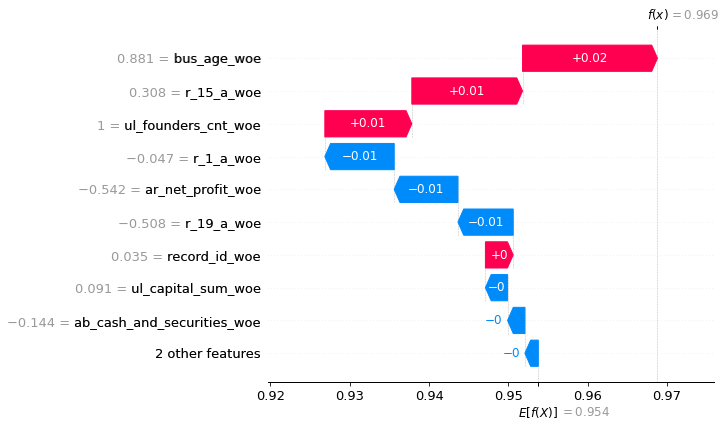

In [ ]:
import xgboost
import shap
X = X_train_woe_phys_final
y = (y_train_woe_phys == 0)  # Convert from string "Yes"/"No" to binary
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

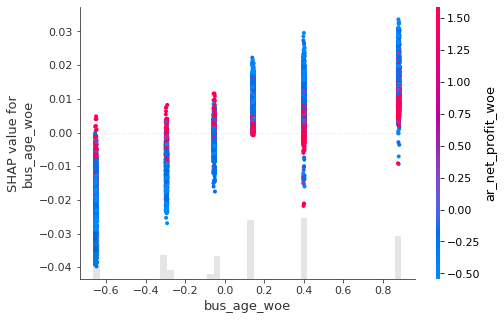

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"bus_age_woe"], color=shap_values)

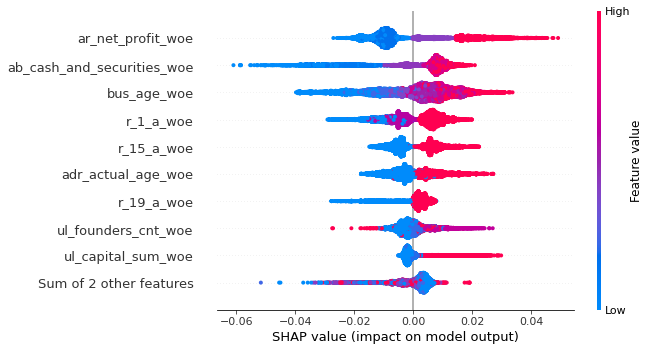

In [ ]:
shap.initjs()
shap.plots.beeswarm(shap_values)

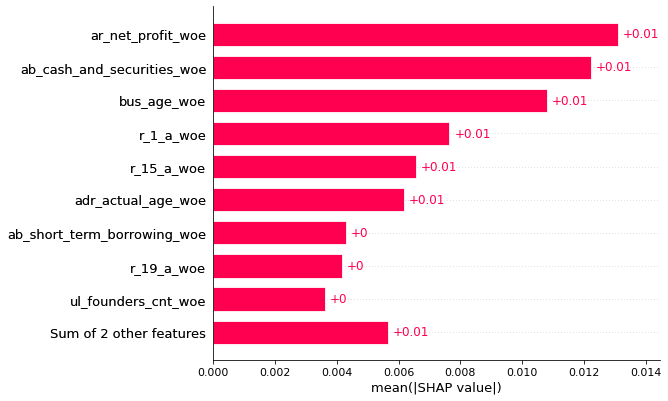

In [ ]:
shap.plots.bar(shap_values)

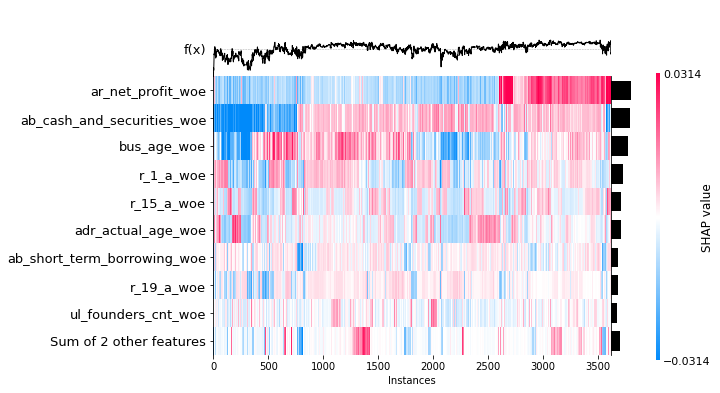

In [ ]:
shap.plots.heatmap(shap_values[:3623])

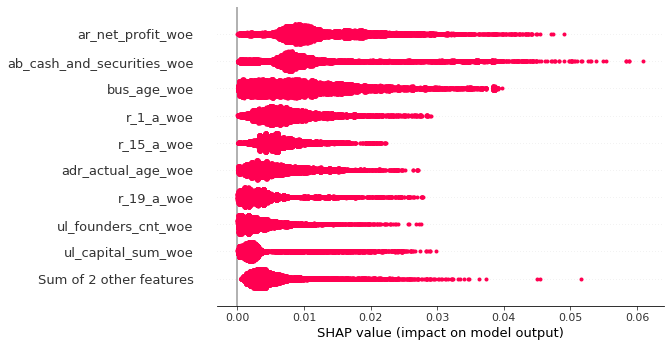

In [ ]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")